# Fairness in Modelling

Fairness is defined to be, “the quality of treating people equally or in a way that is right or reasonable”, in the Cambridge English Dictionary. In the context of Fairness in classification tasks, this means that any decision or outcome predicted from a modelling tool must prevent discrimination against protected population subgroups. To begin to do this, it is first of all important to examine the input data, extract binary protected groups and view it under the lenses of Bias Detection. Once, we are ready to model, we must build the baseline model and consider additional techniques that instill fairness into the algortihm.

## Initial Data Bias Detection

First, define the favourable and unfavourable outcome of their modelling problem and select the protected classes present in their dataset. A protected group or class $\mathbf{S}$ is a category by which people are qualified for special protection by a law, policy, or similar authority. Then identify the **Advantegous or Privileged subset** $\mathbf{S}_{a}$ and the **Disadvantegous or Unprivileged subset** $\mathbf{S}_{d}$ within each protected group. In this context, $S_a$, the advantageous group of a protected attribute (S) that is typically shown to have a higher probability of getting a favourable outcome while $S_d$, the disadvantageous group shows a lower probability of having a favourable outcome. In order to choose the appropriate advantageous and disadvantageous subsets it is useful to plot heatmaps of the frequency of each of the protected groups by target label.

<p class='lead'> Key Definitions: </p>

- **Protected group** is a feature $\mathbf{S}$ that belongs to our input features $\mathbf{X}$
- **Advantageous group / Privileged** is a level $\mathbf{S}_{a}$ of the feature $\mathbf{S}$ having a higher probability of favourable outcome.
- **Disadvantageous group / Unprivileged** is a level $\mathbf{S}_{d}$ of the feature  $\mathbf{S}$ having lower probability of favourable outcome.
- **Actual labels / target** is a categorical variable represented by $\mathbf{Y}$ 
- **Predicted labels** are represented $\hat{Y}$
- *For the mathematical equations the **favourable outcome** is defined to be $\hat{Y} = 1$.*

**Statistical Parity Difference** is a useful method that promotes **data bias detection** upon the initial screening of the input data before modelling algorithms are even considered. It is a way to measure the difference between the **Advantegous** and **Disadvantegous** groups getting a particular outcome. **Disparate Impact** is another metric that can be used to mathematically check if its outcomes are disproportionately hurt (or benefit) people with certain protected attribute values. This is essentially a mathematical rearrangement of the components of Statistical Parity Difference into a ratio. 

**Statistical Parity Difference:**
$$
\begin{align}
\mathbb{P}({Y} = 1 {|} \mathbf{S} = \mathbf{S}_{a}) - \mathbb{P}( {Y}=1{|}\mathbf{S} = \mathbf{S}_{d})
\end{align}
$$

**Disparate Impact:**

$$
\begin{align}
\frac{\mathbb{P}(Y=1{|}S=S_a)} {\mathbb{P}(Y=1{|}S=S_d)}
\end{align}
$$

These metrics provide us with a better idea of the bias inherent in our input data and whether there are unjustified dependencies between protected attributes and the outcome. Such cases can arise when the  data is collected from different sources with different labeling criteria or when the data is generated by a biased decision process. If a classifier is trained directly on such data, these undesirable dependencies will carry over to the classifier’s predictions. Therefore, some intervention is necessary to remove these biases during data pre-processing.

## Causal Reasoning 

<!-- Our graph consists of the protected attribute G, the credit amount, employment length, and credit history attributes and the predicted outcome d.
In causal graphs, a proxy attribute is an attribute whose value can be used to derive a value of another attribute. In our example, we assume that employment length acts as a proxy attribute for G: one can derive the applicants’ gender from the length of their employment.

A resolving attribute is an attribute in the causal graph that is influenced by the protected attribute in a non-discriminatory manner. In our example, the effect of G on the credit amount is non- discriminatory, which means that the differences in credit amount for different values of G are not considered as discrimination. Hence, the credit amount acts as a resolving attribute for G in this graph. -->

**Counterfactual fairness**: A causal graph is counter-factually fair if the predicted outcome $\hat{Y} $ in the graph does not depend on a descendant of the protected attribute $\mathbf{S}$. For  example, a predictive outcome $\hat{Y} $ of defaulter vs non-defaulter for a loan application is typically a dependent on credit history, credit amount, and employment length. If Employment length is a direct descendant of $\mathbf{S}$, the given causal model is not counterfactually fair.

One way to remove these causal dependencies are through explicitly modelling all input variables as a linear combination of the protected class variables. By taking the residuals as a difference between actual and predicted input variables ($X-\hat{X}$) we can effectively remove the correlation between the protected classes to the input variables. 

## Additive counterfactual fair model 

The implementation of a [**linear counterfactually fair**](https://arxiv.org/pdf/1703.06856.pdf) model uses the each of the protected class variable ($\mathbf{S}$) to compute the residuals for each input variable ($\mathbf{X}$) and then calculate the residuals as a difference between actual and predicted values ($\mathbf{X}-\hat{X}$) which is then used to learn a function that maps from inputs to the target variable ($\mathbf{Y}$). 

ACF,within the framework of counterfactual fairness, is the idea that we model the correlations between  ${S}$  and features in  ${X}$  by training linear models to predict each feature  ${X_j}$  using  ${S}$  as input.

Then, we can compute the residuals  ${ϵ_{ij}}$  between predicted and true feature values for each observation  ${i}$  and feature  ${j}$ . The final model is then trained on  ${ϵ_{ij}}$  as features to predict  ${y}$


$$
\begin{array}{c}{X_{1}=\beta_{0}+\beta_{1} S_{1}+\beta_{2} S_{2}+\cdots+\beta_{n} S_{n}+\epsilon_{1}} \\ {X_{n}=\beta_{0}+\beta_{1} S_{1}+\beta_{2} S_{2}+\cdots+\beta_{n} S_{n}+\epsilon_{n}} \\ {\epsilon_{X1}={X_{1}}-\hat{X_{1}}\left(S_{1}, S_{2}, \ldots, S_{n}\right)} \\ {\epsilon_{Xn}={X_{n}}-\hat{X_{n}}\left(S_{1}, S_{2}, \ldots, S_{n}\right)} \\ {Y=\beta_{0}+\beta_{1} \epsilon_{X1}+\cdots+\beta_{n} \epsilon_{Xn}}\end{array}
$$

<p class='lead'> Code Example using the LoanEE2 Dataset: </p>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from numpy import inf
from scipy.stats import kurtosis, skew

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import average_precision_score
from sklearn.metrics import mean_squared_error

from fair_metrics import *
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('ProtectedFeaturesLoanEE2.csv')

#### Select favourable and unfavourable outcome

In [3]:
target='Default'

fav=0
unfav=int(not fav)

#### Identify the protected groups and the respective advantageous and disadvantageous subsets

In [4]:
Male='Gender' #Male/Female (originally work ex less than 10)
Young='Age' #Young/Old
National='Nationality' #Foreign/National
Married='Married' 
Single='Single'
Divorced='Divorced' 
Disabled='Disability' #(originally no of dep <3)

In [5]:
protected_groups=[Male, Young, National, Married, Single, Divorced, Disabled]

In [6]:
adv_groups = [{Male :1}, {Young :0}, {National :1}, {Married :0}, {Single :0}, {Divorced :1}, {Disabled :1}]
disadv_groups = [{Male :0}, {Young :1}, {National :0}, {Married :1}, {Single :1}, {Divorced :0}, {Disabled :0}]

In [7]:
SP=[]
DI=[]
Protected=[]
for groupe in range(0, len(protected_groups)):
    protected_group = list(adv_groups[groupe].keys())[0]
    adv_protected_group_value = adv_groups[groupe][protected_group]
    disadv_protected_group_value = disadv_groups[groupe][protected_group]
    statistical_parity, disparate_impact = statistical_parity_test(data, protected_group,
              adv_protected_group_value, disadv_protected_group_value, target, fav)
    
    SP.append(statistical_parity)
    DI.append(disparate_impact)
    Protected.append(protected_group)

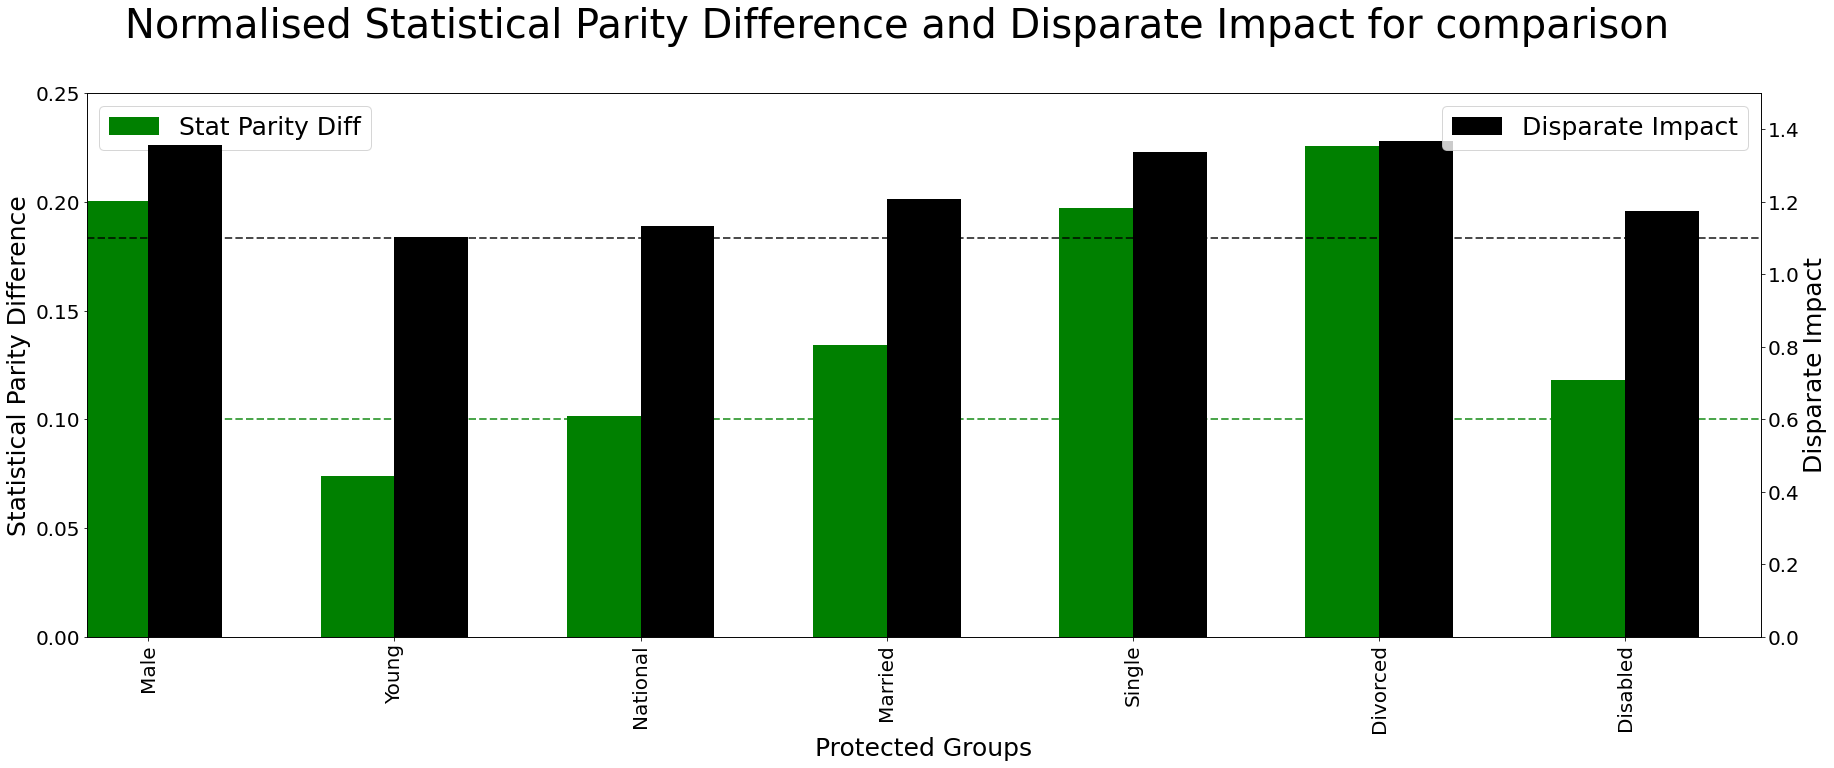

In [8]:
d = pd.DataFrame({'Protected_feature':Protected,'Statistical_Parity':SP,'Disparate_Impact':DI})
d['DI_normal']=d["Disparate_Impact"].apply(lambda x: 1/x if x < 1 else x)
d['SP_normal']=d["Statistical_Parity"].apply(lambda x: abs(x) if x < 0 else x)

fig = plt.figure() 
ax = fig.add_subplot(111) 
ax2 = ax.twinx() # Create another axes that shares the same x-axis as ax.

fig.suptitle('Normalised Statistical Parity Difference and Disparate Impact for comparison', fontsize=40, y=1)

width = 0.3
ax.set_ylim(0, 0.25) 
ax2.set_ylim(0, 1.5) 

d.plot(x ='Protected_feature', y='SP_normal', kind = 'bar', ax=ax, width=width, 
       position=1, color='green', legend=False, figsize=(30,10), fontsize=20)
d.plot(x ='Protected_feature', y='DI_normal', kind = 'bar', ax=ax2, width=width, 
       position=0, color='black', legend=False, figsize=(30,10), fontsize=20)

ax.axhline(y=0.1, linestyle='dashed', linewidth=2, alpha=0.7, color='green')
ax2.axhline(y=1.10, linestyle='dashed', linewidth=2, alpha=0.7, color='black')

patches, labels = ax.get_legend_handles_labels()
ax.legend(patches, ['Stat Parity Diff'], loc='upper left', fontsize=25)

patches, labels = ax2.get_legend_handles_labels()
ax2.legend(patches, ['Disparate Impact'], loc='upper right', fontsize=25)

labels = [item.get_text() for item in ax.get_xticklabels()]

labels[0] = 'Male'
labels[1] = 'Young'
labels[2] = 'National'
labels[3] = 'Married'
labels[4] = 'Single'
labels[5] = 'Divorced'
labels[6] = 'Disabled'

ax.set_xticklabels(labels)
ax.set_xlabel('Protected Groups', fontsize=25)
ax.set_ylabel('Statistical Parity Difference', fontsize=25)
ax2.set_ylabel('Disparate Impact', fontsize=25)

plt.show()

<div class="alert alert-block alert-warning">
<b>Remember:</b>
    
- Here the target variable is:
 - ProbabilityOfDefault
- The independent variables are:
 - Age
 - AppliedAmount
 - ExpectedLoss
 - LiabilitiesTotal
 - IncomeTotal
 - Interest
 - LoanDuration
 - MonthlyPayment
- The sensitive variables are:
 - Male
 - Married
 - Single
 - Divorced
 - Disabled
</div>

In [9]:
biased_protected_groups=[Male, Married, Single, Divorced, Disabled]

In [10]:
choice = Male

#### Fill in missing values

In [11]:
data['MonthlyPayment'].fillna((data['MonthlyPayment'].mean()), inplace=True)
data['ExpectedLoss'].fillna((data['ExpectedLoss'].mean()), inplace=True)
data['ProbabilityOfDefault'].fillna((data['ProbabilityOfDefault'].mean()), inplace=True)
data['DebtToIncome'].fillna((data['DebtToIncome'].mean()), inplace=True)
data['FreeCash'].fillna((data['FreeCash'].mean()), inplace=True)
data['LossGivenDefault'].fillna(0, inplace=True)

In [12]:
dataacf = data[['ProbabilityOfDefault','Age', 'AppliedAmount', 'ExpectedLoss', 'LiabilitiesTotal', 'IncomeTotal', 
                    'Interest', 'LoanDuration', 'MonthlyPayment', Male, Married, Single, Divorced, Disabled]]

## Baseline model : Linear Regression

In [13]:
y=dataacf['ProbabilityOfDefault']*1000
x=dataacf.drop(columns=['ProbabilityOfDefault'])
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=6666)

In [14]:
lin_reg = LinearRegression().fit(X_train, y_train)

In [15]:
y_pred=lin_reg.predict(X_test)
print("For baseline model:")
print("Mean Squared Error:",mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error:", np.sqrt(mean_squared_error(y_test, y_pred)))

For baseline model:
Mean Squared Error: 1993.3127683363584
Root Mean Squared Error: 44.646531425591824


In [16]:
print("For baseline model:")
A_full=mean_squared_error(y_test[X_test[choice]==0], y_pred[X_test[choice]==0]) 
B_full=mean_squared_error(y_test[X_test[choice]==1], y_pred[X_test[choice]==1]) 
print("Mean Squared Error difference:", abs(B_full-A_full))

A_full=np.sqrt(mean_squared_error(y_test[X_test[choice]==0], y_pred[X_test[choice]==0])) 
B_full=np.sqrt(mean_squared_error(y_test[X_test[choice]==1], y_pred[X_test[choice]==1])) 
print("Root Mean Squared Error: difference", abs(B_full-A_full))


For baseline model:
Mean Squared Error difference: 794.4338645987134
Root Mean Squared Error: difference 10.006409796418957


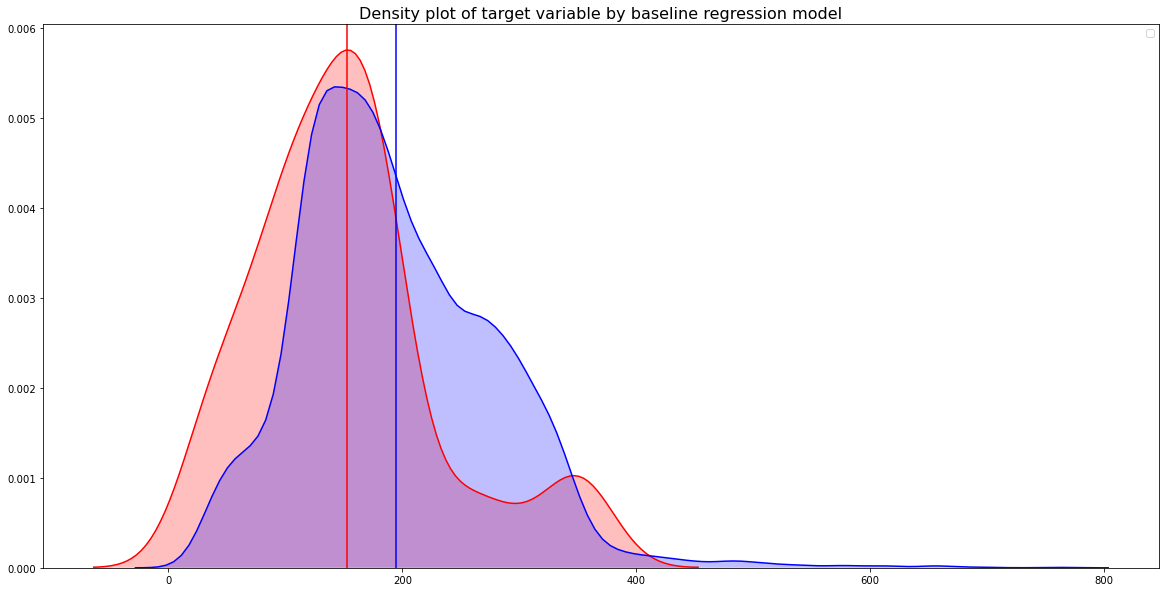

Mean difference of predicted target value (Baseline Model) between two groups: -41.939903423566506
Skewness difference of predicted target value (Baseline Model) between two groups: 0.04273280596069606
Kurtosis difference of predicted target value (Baseline Model) between two groups: -1.3592023741908088


In [17]:
plt.figure(figsize=(20,10))
p1=sns.kdeplot(y_pred[X_test[choice]==0], shade=True, color="r")
p1=sns.kdeplot(y_pred[X_test[choice]==1], shade=True, color="b")

plt.title('Density plot of target variable by baseline regression model', fontsize=16)
plt.axvline(np.mean(y_pred[X_test[choice]==0]), color="r")
plt.axvline(np.mean(y_pred[X_test[choice]==1]), color="b")

plt.legend('a', 'b')
plt.show()

print("Mean difference of predicted target value (Baseline Model) between two groups:", np.mean(y_pred[X_test[choice]==0]) - 
      np.mean(y_pred[X_test[choice]==1]))
print("Skewness difference of predicted target value (Baseline Model) between two groups:", skew(y_pred[X_test[choice]==0]) - 
      skew(y_pred[X_test[choice]==1]))
print("Kurtosis difference of predicted target value (Baseline Model) between two groups:", kurtosis(y_pred[X_test[choice]==0]) - 
      kurtosis(y_pred[X_test[choice]==1]))

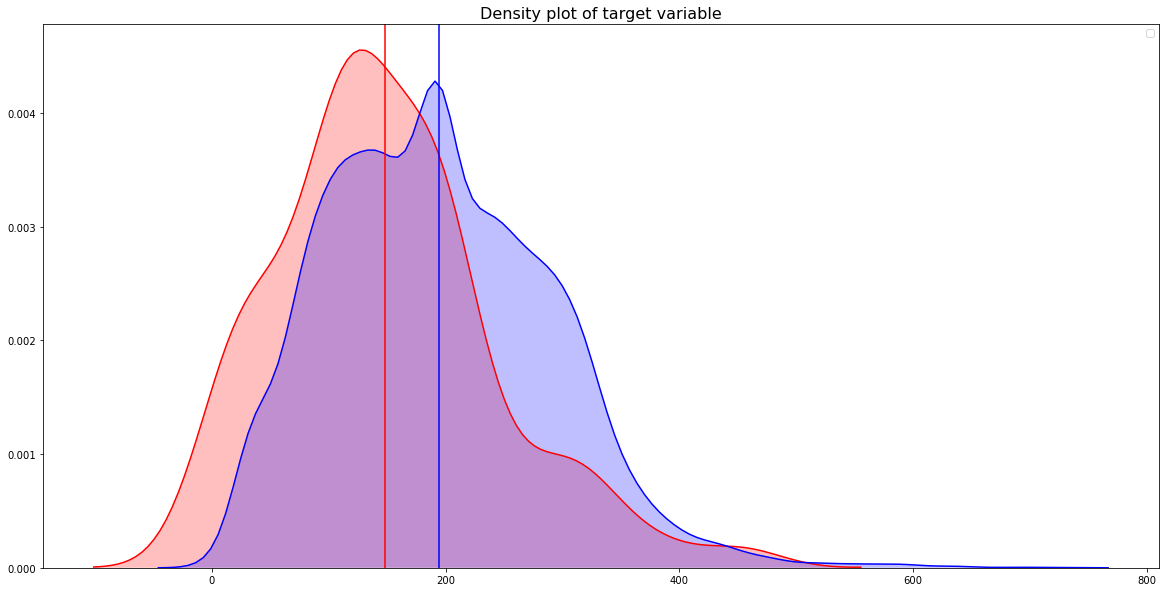

Mean difference of target value between two groups: -45.71763227847788
Skewness difference of target value between two groups: 0.23210926729434522
Kurtosis difference of target value between two groups: 0.2919506543878603


In [18]:
plt.figure(figsize=(20,10))
p1=sns.kdeplot(y_test[X_test[choice]==0], shade=True, color="r")
p1=sns.kdeplot(y_test[X_test[choice]==1], shade=True, color="b")
#print(np.mean(y_test[X_test[choice]==0])-(np.mean(y_test[X_test[choice]==1])))

plt.title('Density plot of target variable', fontsize=16)
plt.axvline(np.mean(y_test[X_test[choice]==0]), color="r")
plt.axvline(np.mean(y_test[X_test[choice]==1]), color="b")

plt.legend('a','b')
plt.show()

print("Mean difference of target value between two groups:", np.mean(y_test[X_test[choice]==0]) -
      (np.mean(y_test[X_test[choice]==1])))
print("Skewness difference of target value between two groups:", skew(y_test[X_test[choice]==0]) -
      (skew(y_test[X_test[choice]==1])))
print("Kurtosis difference of target value between two groups:", kurtosis(y_test[X_test[choice]==0]) -
      (kurtosis(y_test[X_test[choice]==1])))

## Additive counterfactual fair model


In [19]:
y=dataacf['ProbabilityOfDefault']*1000
x=dataacf.drop(columns=['ProbabilityOfDefault'])
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=6666)

## Use the ACF class

In [20]:
independent_vars = ['Age', 'AppliedAmount', 'ExpectedLoss', 'LiabilitiesTotal', 'IncomeTotal', 
                    'Interest', 'LoanDuration', 'MonthlyPayment']
biased_protected_groups = [Male,Married,Single,Divorced,Disabled]

sens_train = X_train[biased_protected_groups]
sens_test = X_test[biased_protected_groups]

In [21]:
import ACF as acf_class

acf = acf_class.ACF(X_train, X_test, y_train, y_test, sens_train, sens_test, independent_vars)
main_model = LinearRegression()

acf_model = acf.fit(main_model)

In [22]:
y_pred_fair_class = acf.predict()

In [23]:
acf.score()

Accuracy of additive counterfactual fair model: 0.6910971607330189


0.6910971607330189

In [24]:
print("For acf model:")
print("Mean Squared Error:",mean_squared_error(y_test, y_pred_fair_class))
print("Root Mean Squared Error:", np.sqrt(mean_squared_error(y_test, y_pred_fair_class)))

For acf model:
Mean Squared Error: 2787.8281433294587
Root Mean Squared Error: 52.799887720803525


In [25]:
print("For acf model:")
A_full=mean_squared_error(y_test[sens_test[choice]==0], y_pred_fair_class[sens_test[choice]==0]) #pval = 0 is Privileged
B_full=mean_squared_error(y_test[sens_test[choice]==1], y_pred_fair_class[sens_test[choice]==1]) #pval = 1 is Unprivileged
print("Mean Squared Error difference:", abs(B_full-A_full))

A_full=np.sqrt(mean_squared_error(y_test[sens_test[choice]==0], y_pred_fair_class[sens_test[choice]==0])) 
B_full=np.sqrt(mean_squared_error(y_test[sens_test[choice]==1], y_pred_fair_class[sens_test[choice]==1])) 
print("Root Mean Squared Error: difference", abs(B_full-A_full))


For acf model:
Mean Squared Error difference: 147.62654752642402
Root Mean Squared Error: difference 1.4167662629544324


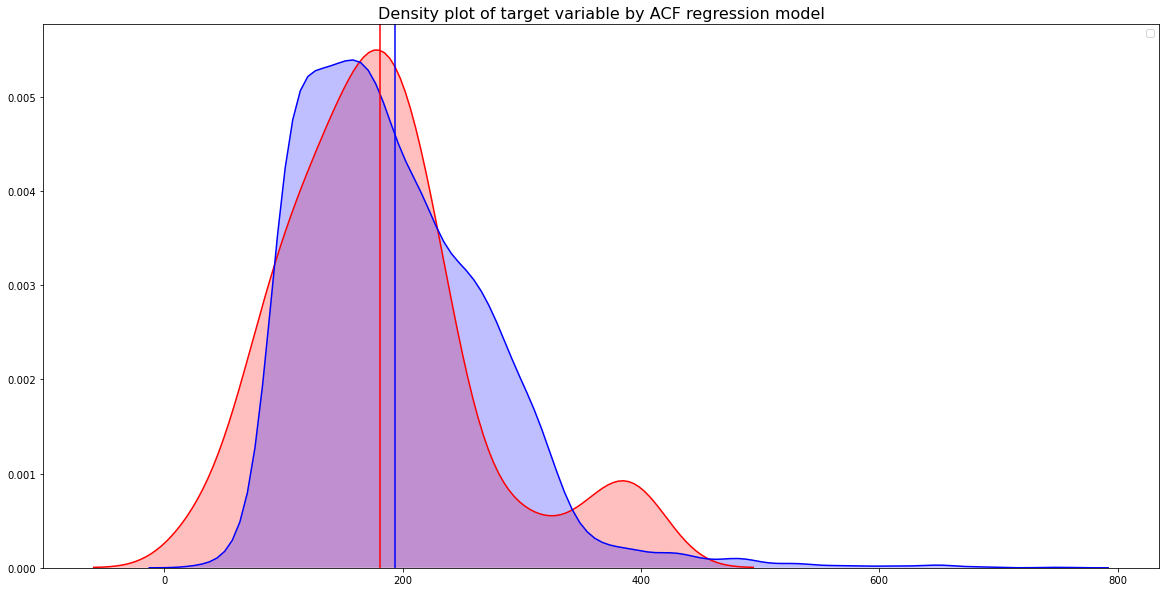

Mean difference of predicted target value (ACF Model) between two groups: -12.617938545725934
Skewness difference of predicted target value (ACF Model) between two groups: -0.3517927948261186
Kurtosis difference of predicted target value (ACF Model) between two groups: -2.4666880345029196


In [26]:
plt.figure(figsize=(20,10))
p1=sns.kdeplot(y_pred_fair_class[sens_test[choice]==0], shade=True, color="r")
p1=sns.kdeplot(y_pred_fair_class[sens_test[choice]==1], shade=True, color="b")
#print(np.mean(y_pred[X_test[choice]==0]) - np.mean(y_pred[X_test[choice]==1]))

plt.title('Density plot of target variable by ACF regression model', fontsize=16)
plt.axvline(np.mean(y_pred_fair_class[sens_test[choice]==0]), color="r")
plt.axvline(np.mean(y_pred_fair_class[sens_test[choice]==1]), color="b")

plt.legend('a', 'b')
plt.show()

print("Mean difference of predicted target value (ACF Model) between two groups:", np.mean(y_pred_fair_class[sens_test[choice]==0]) - 
      np.mean(y_pred_fair_class[sens_test[choice]==1]))
print("Skewness difference of predicted target value (ACF Model) between two groups:", skew(y_pred_fair_class[sens_test[choice]==0]) - 
      skew(y_pred_fair_class[sens_test[choice]==1]))
print("Kurtosis difference of predicted target value (ACF Model) between two groups:", kurtosis(y_pred_fair_class[sens_test[choice]==0]) - 
      kurtosis(y_pred_fair_class[sens_test[choice]==1]))

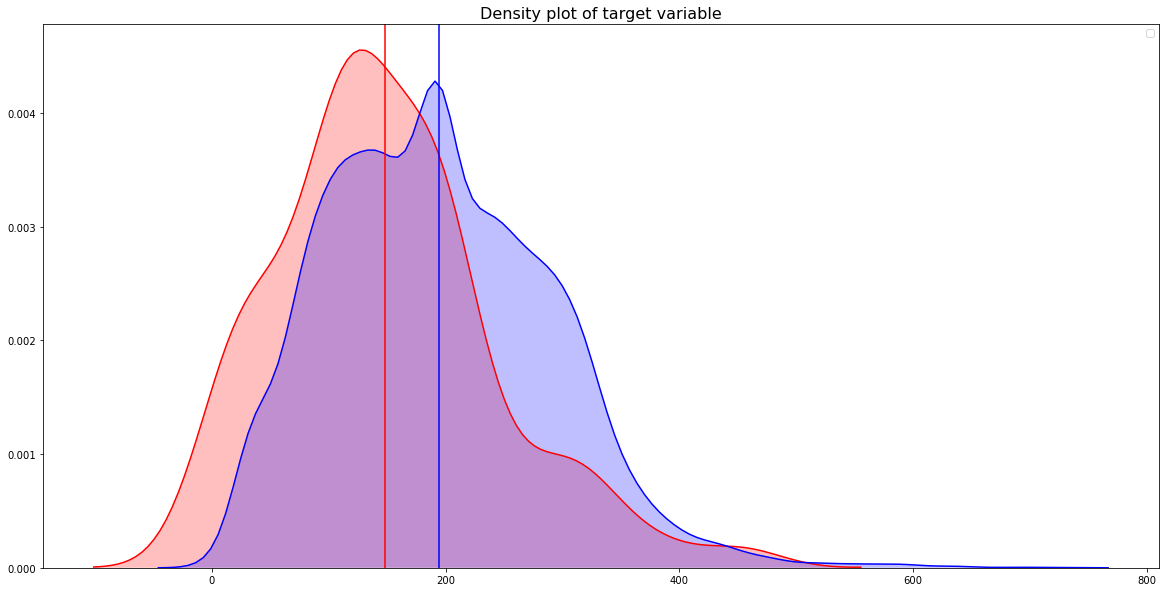

Mean difference of target value between two groups: -45.71763227847788
Skewness difference of target value between two groups: 0.23210926729434522
Kurtosis difference of target value between two groups: 0.2919506543878603


In [27]:
plt.figure(figsize=(20,10))
p1=sns.kdeplot(y_test[X_test[choice]==0], shade=True, color="r")
p1=sns.kdeplot(y_test[X_test[choice]==1], shade=True, color="b")
#print(np.mean(y_test[X_test[choice]==0])-(np.mean(y_test[X_test[choice]==1])))

plt.title('Density plot of target variable', fontsize=16)
plt.axvline(np.mean(y_test[X_test[choice]==0]), color="r")
plt.axvline(np.mean(y_test[X_test[choice]==1]), color="b")

plt.legend('a','b')
plt.show()

print("Mean difference of target value between two groups:", np.mean(y_test[X_test[choice]==0]) -
      (np.mean(y_test[X_test[choice]==1])))
print("Skewness difference of target value between two groups:", skew(y_test[X_test[choice]==0]) -
      (skew(y_test[X_test[choice]==1])))
print("Kurtosis difference of target value between two groups:", kurtosis(y_test[X_test[choice]==0]) -
      (kurtosis(y_test[X_test[choice]==1])))

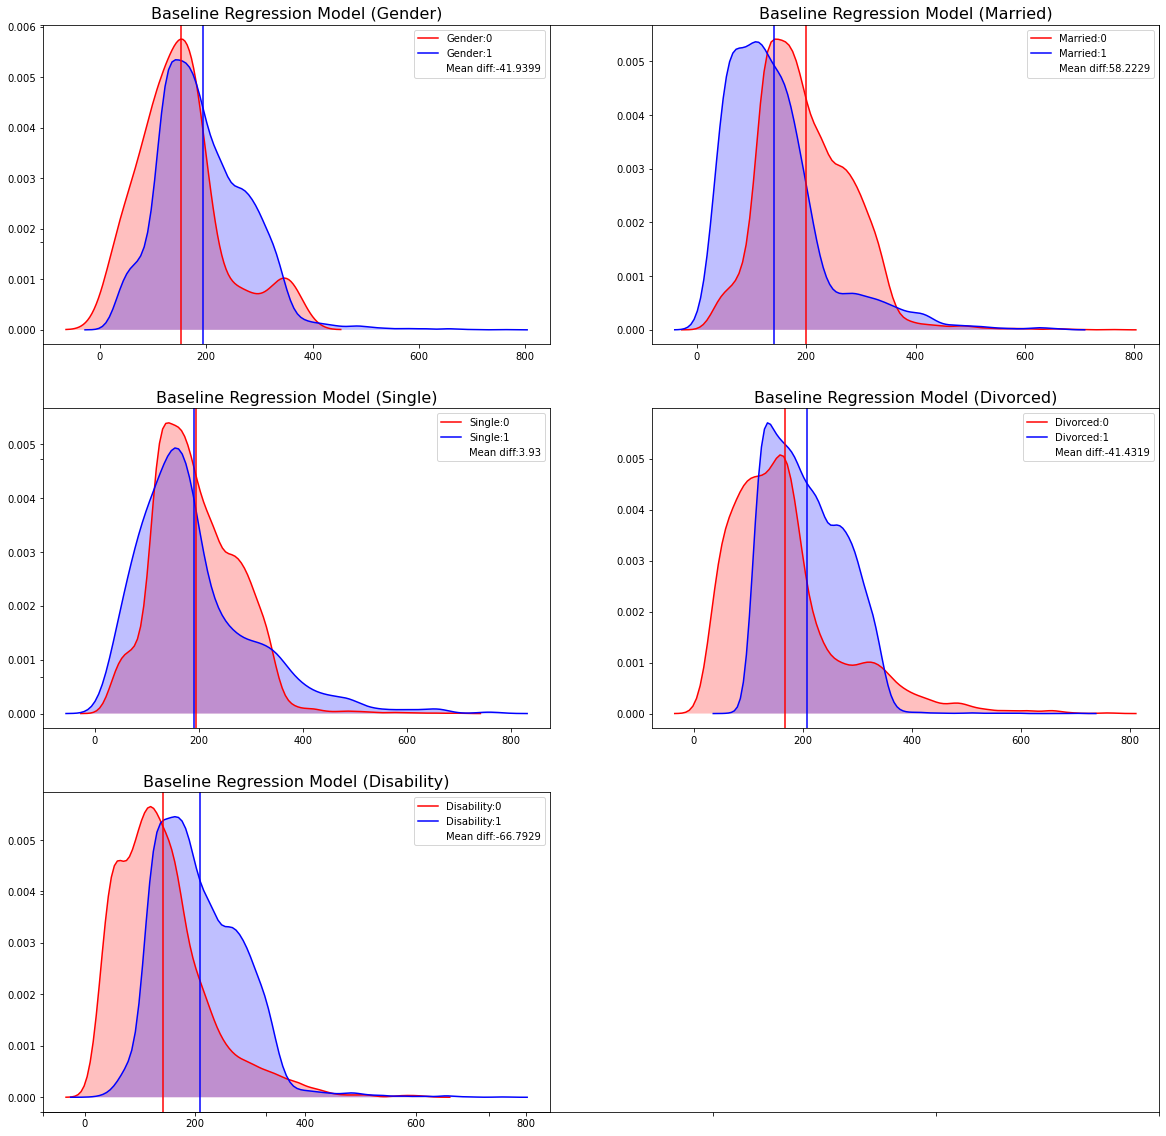

In [28]:
fig, ax = plt.subplots(figsize=(20,20))
ax.tick_params(labelbottom=False, labelleft=False) 
for groupe in range(0, len(biased_protected_groups)):
    choice = biased_protected_groups[groupe]
#     plt.figure(figsize=(20,10))
    ax = fig.add_subplot(3,2,groupe+1)
    p1=sns.kdeplot(y_pred[X_test[choice]==0], shade=True, color="r", label ='{}:0'.format(choice))
    p1=sns.kdeplot(y_pred[X_test[choice]==1], shade=True, color="b", label ='{}:1'.format(choice))

    plt.title("Baseline Regression Model ({})".format(choice), fontsize=16)
    plt.axvline(np.mean(y_pred[X_test[choice]==0]), color="r")
    plt.axvline(np.mean(y_pred[X_test[choice]==1]), color="b")
    plt.plot([], [], ' ', label="Mean diff:{}".format(round(np.mean(y_pred[X_test[choice]==0]) - np.mean(y_pred[X_test[choice]==1]), 4)))

    plt.legend()
plt.show()

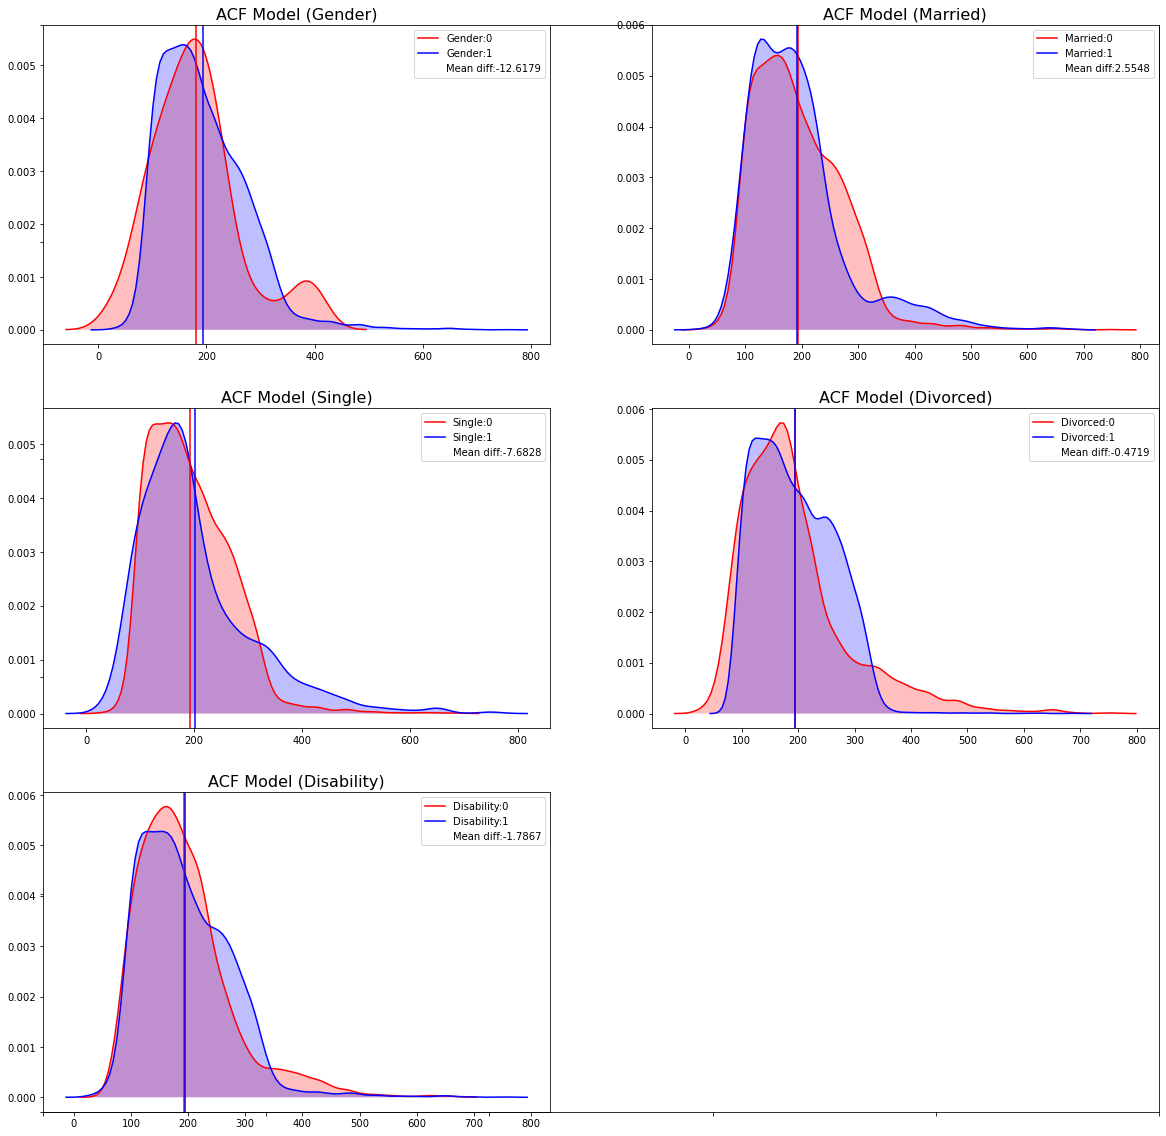

In [29]:
fig, ax = plt.subplots(figsize=(20,20))
ax.tick_params(labelbottom=False, labelleft=False) 
for groupe in range(0, len(biased_protected_groups)):
    choice = biased_protected_groups[groupe]
#     plt.figure(figsize=(20,10))
    ax = fig.add_subplot(3,2,groupe+1)
    p1=sns.kdeplot(y_pred_fair_class[sens_test[choice]==0], shade=True, color="r", label ='{}:0'.format(choice))
    p1=sns.kdeplot(y_pred_fair_class[sens_test[choice]==1], shade=True, color="b", label ='{}:1'.format(choice))

    plt.title("ACF Model ({})".format(choice), fontsize=16)
    plt.axvline(np.mean(y_pred_fair_class[sens_test[choice]==0]), color="r")
    plt.axvline(np.mean(y_pred_fair_class[sens_test[choice]==1]), color="b")
    plt.plot([], [], ' ', label="Mean diff:{}".format(round(np.mean(y_pred_fair_class[sens_test[choice]==0]) - np.mean(y_pred_fair_class[sens_test[choice]==1]), 4)))

    plt.legend()
plt.show()

### Proxy model = LinearRegressor()
**Summary of Model performance (Male)**

Metrics  | Data | Baseline | ACF |
------------- | ------------- | ------------ | ------------ |
Mean  | -45.7 |-41.9| -12.6
Skewness  | 0.23|0.04|-0.35
Kurtosis  | 0.29|-1.92|-2.46

**Summary of Model performance (Married)**

Metrics  | Data | Baseline | ACF |
------------- | ------------- | ------------ | ------------ |
Mean  | 59.5 |58.2| 2.55
Skewness  | -0.83|-0.82| -0.47
Kurtosis  | -1.83|-1.88| -0.49

**Summary of Model performance (Divorced)**

Metrics  | Data | Baseline | ACF |
------------- | ------------- | ------------ | ------------ |
Mean  | -41.8 |41.43| -0.47
Skewness  | 1.02|1.03| 1.06
Kurtosis  | 2.21|3.19| 3.10

**Summary of Model performance (Disabled)**

Metrics  | Data | Baseline  | ACF |
------------- | ------------- | ------------ | ------------ |
Mean  | -66.9 |-66.8| -1.79
Skewness  | 0.61|0.37| 0.32
Kurtosis  | 1.15|0.32| 0.09
